Natural Language Processing (NLP): You’ve been handed a large collection of text documents (akin to the 20 Newsgroups dataset) representing community forum posts. Your task is to quickly categorize or label these posts so that the support team can route questions to the right channels more efficiently.

You have a large set of forum or user-post data that needs categorization to streamline support requests. Imagine receiving posts about technical issues, general inquiries, and miscellaneous topics.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
!pip install gensim
from collections import Counter
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from gensim.models import Word2Vec

# For text preprocessing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
from nltk import pos_tag

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

# For dataset loading
from sklearn.datasets import fetch_20newsgroups

# Set random seed for reproducibility
np.random.seed(42)

# Load a subset of the 20 Newsgroups dataset
categories = ['comp.graphics', 'rec.autos', 'sci.space', 'talk.politics.misc']
newsgroups = fetch_20newsgroups(subset='train', categories=categories, random_state=42)

df = pd.DataFrame({
    'text': newsgroups.data,
    'category': [newsgroups.target_names[target] for target in newsgroups.target]
})

# import tarfile

# # Path to the .tar.gz file you downloaded
# archive_path = r"C:\Users\jtlee\OneDrive\Documents\Flatiron Schoolwork\DS_09 Natural Language Processing\20news-bydate.tar.gz"

# # Folder where you want to extract it
# extract_path = r"C:\Users\jtlee\OneDrive\Documents\Flatiron Schoolwork\DS_09 Natural Language Processing\20news-bydate"

# with tarfile.open(archive_path, 'r:gz') as tar:
#     tar.extractall(path=extract_path)

# # Load from the extracted folder
# newsgroups = load_files(
#     r"C:\Users\jtlee\OneDrive\Documents\Flatiron Schoolwork\DS_09 Natural Language Processing\20news-bydate\20news-bydate-train",
#     categories=categories,
#     encoding='utf-8',
#     decode_error='ignore',
#     shuffle=True,
#     random_state=42
# )

# # Create a DataFrame for easier manipulation
# df = pd.DataFrame({
#    'text': newsgroups.data,
#    'category': [newsgroups.target_names[target] for target in newsgroups.target]
# })

# Preview the data
# Examine the dataset’s shape, category distribution, and initial snippets to understand text length, variety, and possible cleaning requirements.
print(f"Dataset shape: {df.shape}")
print("\nCategory distribution:")
print(df['category'].value_counts())
print("\nSample document:")
print(df['text'][10][:500])  # Print first 500 characters of a sample document

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


Dataset shape: (2236, 2)

Category distribution:
category
rec.autos             594
sci.space             593
comp.graphics         584
talk.politics.misc    465
Name: count, dtype: int64

Sample document:
From: bob1@cos.com (Bob Blackshaw)
Subject: Re: Dumbest Driver Action
Organization: Corporation for Open Systems
Distribution: usa 
Lines: 41

In <C5Dq2n.5uB@news.cso.uiuc.edu> mwbg9715@uxa.cso.uiuc.edu (Mark Wayne Blunier) writes:

>jimf@centerline.com (Jim Frost) writes:

>>I wish I had the figures with me to back me up, but I recall
>>statistics showing that women tended to have more accidents than men
>>but the damage was generally quite minor.  Men had fewer but far more
>>expensive acciden


Convert text to lowercase, remove punctuation, and handle potential numerical or URL patterns.

Apply tokenization and either lemmatize or stem tokens, removing stopwords as needed.

Consider how each choice (e.g., removing stopwords) might impact your classification later.

In [2]:
print(df.head())

                                                text            category
0  From: nfotis@ntua.gr (Nick C. Fotis)\nSubject:...       comp.graphics
1  From: cdm@pmafire.inel.gov (Dale Cook)\nSubjec...  talk.politics.misc
2  From: rick@trystro.uucp (Richard Nickle)\nSubj...           sci.space
3  From: marshatt@feserve.cc.purdue.edu (Zauberer...           rec.autos
4  From: Clinton-HQ@Campaign92.Org (Clinton/Gore ...  talk.politics.misc


In [3]:
# Lemmatizer relies of part of speech to help
def get_wordnet_pos(treebank_tag):
  '''
  Translate nltk POS to wordnet tags
  '''
  if treebank_tag.startswith('J'):
      return wordnet.ADJ
  elif treebank_tag.startswith('V'):
      return wordnet.VERB
  elif treebank_tag.startswith('N'):
      return wordnet.NOUN
  elif treebank_tag.startswith('R'):
      return wordnet.ADV
  else:
      return wordnet.NOUN

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text, remove_stopwords=True, lemmatize=True):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters/numbers
    text = re.sub(r'\S+@\S+', '', text)  # remove emails
    text = re.sub(r'http\S+|www\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # tag with pos
    tokens_tagged = pos_tag(tokens)
    pos_tokens = [(word[0], get_wordnet_pos(word[1])) for word in tokens_tagged]

    # Optional: Remove stopwords
    # Lemmatize or stem tokens
    if remove_stopwords and lemmatize:
        cleaned_tokens = [lemmatizer.lemmatize(token[0], token[1]) for token in pos_tokens if token[0] not in stop_words and len(token[0]) > 1]

    # Return the cleaned token list
    # a single string of tokens
    return ' '.join(cleaned_tokens)

# apply preprocessing to the text column
df['cleaned_text'] = df['text'].apply(preprocess_text)

# tokenize the cleaned text
df['processed_tokens'] = df['cleaned_text'].apply(word_tokenize)

After transforming your text, generate frequency counts or n-grams (bigrams/trigrams) to see common phrases.

Interpret results to understand domain-specific language usage. For example, frequent terms might highlight which support categories are most common.

In [4]:
from collections import Counter

# Single words
counter = Counter([token for doc in df['processed_tokens'] for token in doc])
print(counter.most_common(20))

# Bigrams
from nltk.util import ngrams
bigram_counts = Counter(ngrams(df['processed_tokens'].sum(), 2))
print(bigram_counts.most_common(20))

[('line', 2595), ('subject', 2389), ('organization', 2305), ('would', 1970), ('write', 1750), ('get', 1721), ('article', 1664), ('one', 1563), ('use', 1540), ('go', 1354), ('space', 1293), ('dont', 1282), ('think', 1280), ('make', 1270), ('car', 1263), ('say', 1248), ('know', 1239), ('like', 1227), ('university', 1149), ('people', 1119)]
[(('line', 'article'), 607), (('line', 'nntppostinghost'), 385), (('organization', 'university'), 374), (('mr', 'stephanopoulos'), 341), (('write', 'article'), 291), (('dont', 'know'), 211), (('distribution', 'world'), 207), (('line', 'distribution'), 204), (('usa', 'line'), 199), (('distribution', 'usa'), 146), (('writes', 'article'), 134), (('replyto', 'organization'), 134), (('dont', 'think'), 131), (('would', 'like'), 122), (('united', 'state'), 120), (('university', 'line'), 119), (('world', 'nntppostinghost'), 118), (('clayton', 'cramer'), 114), (('anyone', 'know'), 112), (('state', 'university'), 110)]


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'],
    df['category'],
    test_size=0.2,
    random_state=42,
    stratify=df['category'])

# split tokenized data
X_train_tokens = df.loc[X_train.index, 'processed_tokens']
X_test_tokens = df.loc[X_test.index, 'processed_tokens']

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"Class distribution in training set: \n{y_train.value_counts()}")
print(f"Class distribution in testing set: \n{y_test.value_counts()}")

Training set size: 1788
Testing set size: 448
Class distribution in training set: 
category
rec.autos             475
sci.space             474
comp.graphics         467
talk.politics.misc    372
Name: count, dtype: int64
Class distribution in testing set: 
category
sci.space             119
rec.autos             119
comp.graphics         117
talk.politics.misc     93
Name: count, dtype: int64


In [6]:
# Bag of words vectorizer
count_vectorizer = CountVectorizer(
    preprocessor = preprocess_text,
    lowercase=False,  # Already lowercased in preprocess_text
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.95,  # Ignore terms that appear in more than 95% of documents
    ngram_range=(1, 2)  # Use unigrams and bigrams
)

# TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    preprocessor = preprocess_text,
    lowercase=False,  # Already lowercased in preprocess_text
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.95,  # Ignore terms that appear in more than 95% of documents
    ngram_range=(1, 2)  # Use unigrams and bigrams
)

# apply vectorizers to training data
X_train_counts = count_vectorizer.fit_transform(X_train)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# get feature info
count_features = count_vectorizer.get_feature_names_out()
tfidf_features = tfidf_vectorizer.get_feature_names_out()

print(f"Bag of Words features: {len(count_features)}")
print(f"TF-IDF features: {len(tfidf_features)}")
print(f"Sample BoW features: {count_features[:10]}")
print(f"Sample TF-IDF features (including bigrams): {[f for f in tfidf_features[:20] if ' ' in f][:5]}")


Bag of Words features: 46485
TF-IDF features: 46485
Sample BoW features: ['aa' 'aa fri' 'aa thu' 'aaa' 'aamir' 'aamir hafeez' 'aamir qazi'
 'aammmaaaazzzzzziinnnnggggg' 'aammmaaaazzzzzziinnnnggggg prediction'
 'aaron']
Sample TF-IDF features (including bigrams): ['aa fri', 'aa thu', 'aamir hafeez', 'aamir qazi', 'aammmaaaazzzzzziinnnnggggg prediction']


In [7]:
# train a Word2Vec model on dataset
w2v_model = Word2Vec(
    df['processed_tokens'],
    vector_size=100,
    window=5,
    min_count=2,
    workers=20,
    sg=1
)

# Function to create document vectors by averaging word vectors
def document_to_vector(tokens, model, vector_size=100):
   """Convert a document (list of tokens) to a vector using word embeddings."""
   # Initialize an empty vector
   doc_vector = np.zeros(vector_size)

   # Count valid tokens
   valid_token_count = 0

   # Sum up vectors for each token
   for token in tokens:
       if token in model.wv:
           doc_vector += model.wv[token]
           valid_token_count += 1

   # Average the vectors
   if valid_token_count > 0:
       doc_vector /= valid_token_count

   return doc_vector

def document_to_vector_pretrained(tokens, model, vector_size=300):
   """Convert a document (list of tokens) to a vector using word embeddings."""
   # Initialize an empty vector
   doc_vector = np.zeros(vector_size)

   # Count valid tokens
   valid_token_count = 0

   # Sum up vectors for each token
   for token in tokens:
       if token in model:
           doc_vector += model[token]
           valid_token_count += 1

   # Average the vectors
   if valid_token_count > 0:
       doc_vector /= valid_token_count

   return doc_vector

# Create document vectors for training and test sets
X_train_w2v = np.array([document_to_vector(tokens, w2v_model) for tokens in X_train_tokens])
X_test_w2v = np.array([document_to_vector(tokens, w2v_model) for tokens in X_test_tokens])
print(f"Word2Vec document vectors shape: {X_train_w2v.shape}")

Word2Vec document vectors shape: (1788, 100)


In [8]:
# Train with Bag of Words features
nb_bow = MultinomialNB(alpha=1.0)
nb_bow.fit(X_train_counts, y_train)

# Train with TF-IDF features
nb_tfidf = MultinomialNB(alpha=1.0)
nb_tfidf.fit(X_train_tfidf, y_train)

# For Word2Vec features, we need to convert the data to a non-negative representation
# because Multinomial NB requires non-negative feature values
# One simple approach is min-max scaling
def min_max_scale(X):
   """Scale features to [0, 1] range."""
   X_min = X.min(axis=0)
   X_max = X.max(axis=0)
   return (X - X_min) / (X_max - X_min + 1e-10)  # Adding a small epsilon to avoid division by zero

X_train_w2v_scaled = min_max_scale(X_train_w2v)
X_test_w2v_scaled = min_max_scale(X_test_w2v)

# Train with Word2Vec features
nb_w2v = MultinomialNB(alpha=1.0)
nb_w2v.fit(X_train_w2v_scaled, y_train)

# Function to display top features by class
def display_top_features(classifier, vectorizer, class_labels, n=10):
   """Display the top n words for each class based on their likelihood."""
   feature_names = vectorizer.get_feature_names_out()
   for i, class_label in enumerate(class_labels):
       top_indices = np.argsort(classifier.feature_log_prob_[i])[-n:][::-1]
       top_features = [feature_names[j] for j in top_indices]
       print(f"\nTop words for '{class_label}':")
       print(", ".join(top_features))

# Display top features for Bag of Words model
print("\nTop discriminative features per department (Bag of Words model):")

display_top_features(nb_bow, count_vectorizer, nb_bow.classes_)

# Display top features for BoW model, focusing on bigrams
print("\nTop discriminative bigrams per department (Bag of Words model):")

def display_top_ngrams(classifier, vectorizer, class_labels, n=5):
   """Display the top n bigrams for each class based on their likelihood."""
   feature_names = vectorizer.get_feature_names_out()
   # Get indices of all bigram features
   bigram_indices = [i for i, feat in enumerate(feature_names) if ' ' in feat]

   for i, class_label in enumerate(class_labels):
       # Filter to only consider bigram features
       bigram_log_probs = [(j, classifier.feature_log_prob_[i][j]) for j in bigram_indices]
       # Sort by probability (highest first)
       top_bigram_indices = sorted(bigram_log_probs, key=lambda x: x[1], reverse=True)[:n]
       top_bigrams = [feature_names[j] for j, _ in top_bigram_indices]
       print(f"\nTop bigrams for '{class_label}':")
       print(", ".join(top_bigrams))

display_top_ngrams(nb_bow, count_vectorizer, nb_bow.classes_)


Top discriminative features per department (Bag of Words model):

Top words for 'comp.graphics':
image, file, use, graphic, write, program, university, get, know, would

Top words for 'rec.autos':
car, get, article, would, write, one, like, go, good, dont

Top words for 'sci.space':
space, would, launch, one, write, article, use, get, nasa, like

Top words for 'talk.politics.misc':
would, people, say, make, go, think, article, write, one, get

Top discriminative bigrams per department (Bag of Words model):

Top bigrams for 'comp.graphics':
organization university, line nntppostinghost, line article, distribution world, xnewsreader tin

Top bigrams for 'rec.autos':
line article, organization university, distribution usa, usa line, write article

Top bigrams for 'sci.space':
line article, line nntppostinghost, organization university, henry spencer, space station

Top bigrams for 'talk.politics.misc':
mr stephanopoulos, line article, write article, clayton cramer, united state



Bag of Words Model Performance:
Accuracy: 0.9710

Classification Report:
                    precision    recall  f1-score   support

     comp.graphics       0.95      0.98      0.97       117
         rec.autos       0.98      0.97      0.98       119
         sci.space       0.97      0.95      0.96       119
talk.politics.misc       0.98      0.98      0.98        93

          accuracy                           0.97       448
         macro avg       0.97      0.97      0.97       448
      weighted avg       0.97      0.97      0.97       448



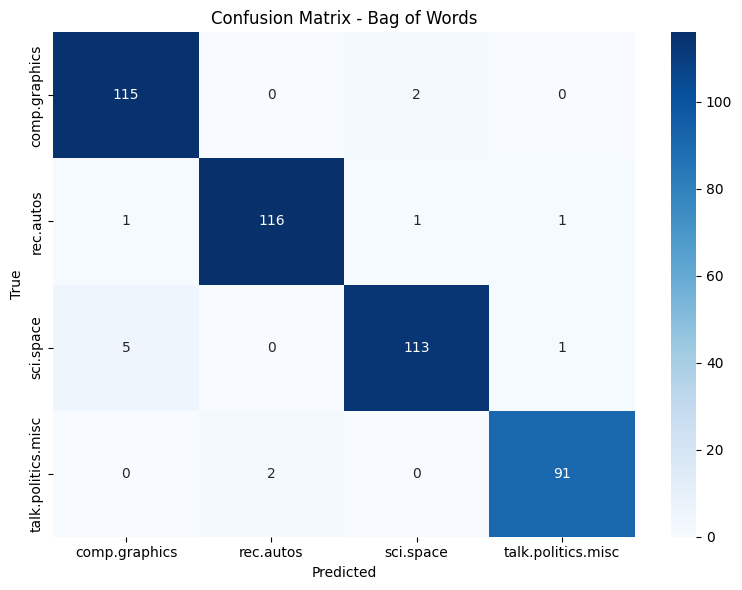


TF-IDF Model Performance:
Accuracy: 0.9799

Classification Report:
                    precision    recall  f1-score   support

     comp.graphics       0.97      0.98      0.97       117
         rec.autos       0.98      0.99      0.99       119
         sci.space       0.97      0.97      0.97       119
talk.politics.misc       1.00      0.98      0.99        93

          accuracy                           0.98       448
         macro avg       0.98      0.98      0.98       448
      weighted avg       0.98      0.98      0.98       448



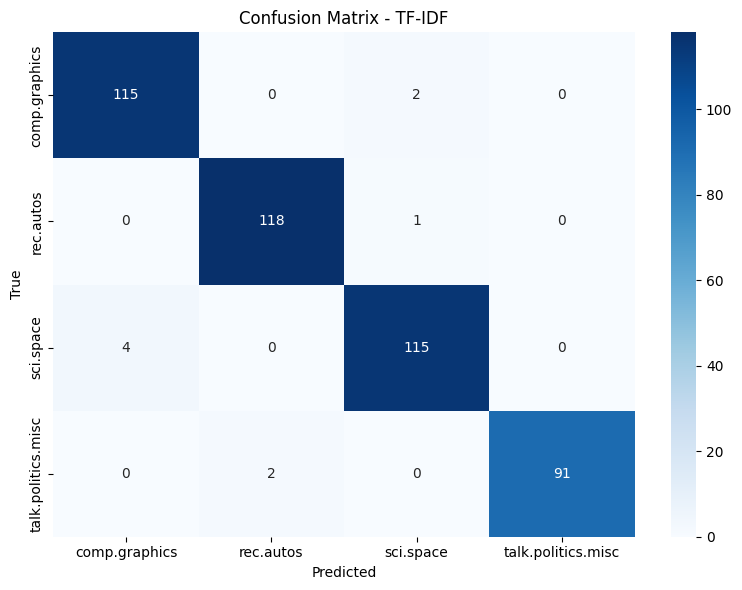


Word2Vec Model Performance:
Accuracy: 0.8795

Classification Report:
                    precision    recall  f1-score   support

     comp.graphics       0.85      0.91      0.88       117
         rec.autos       0.81      0.92      0.87       119
         sci.space       0.92      0.86      0.89       119
talk.politics.misc       0.99      0.81      0.89        93

          accuracy                           0.88       448
         macro avg       0.89      0.88      0.88       448
      weighted avg       0.89      0.88      0.88       448



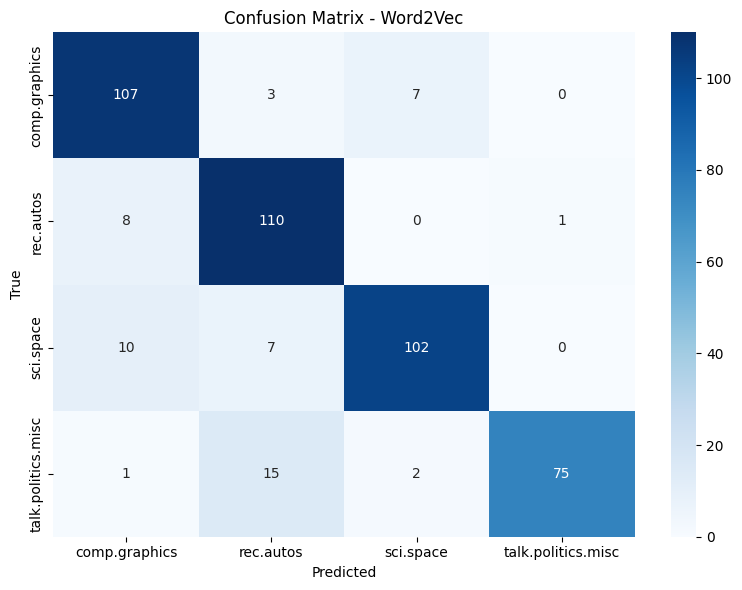

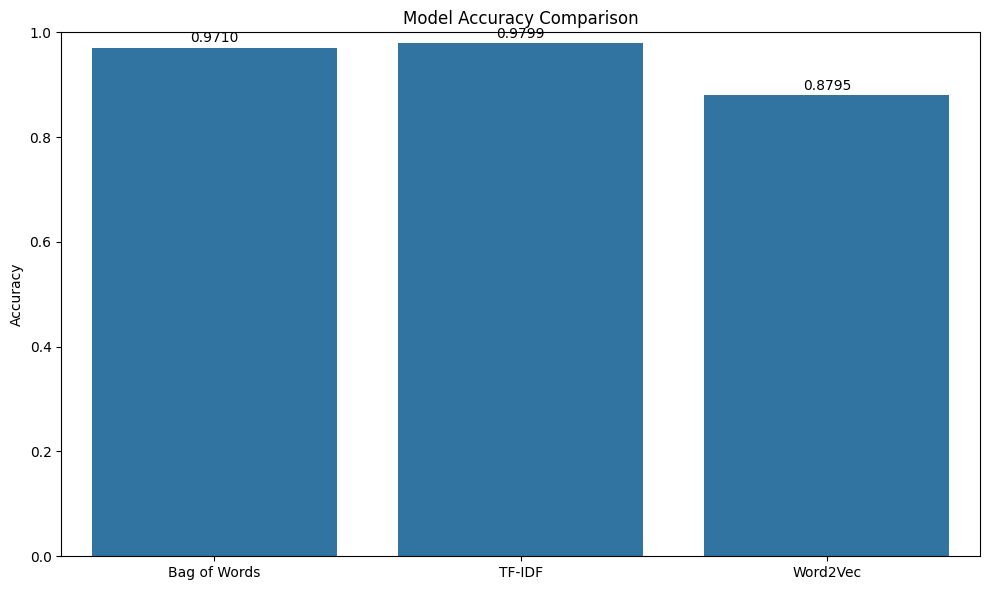

In [9]:
# Transform test data using the fitted vectorizers
X_test_counts = count_vectorizer.transform(X_test)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Word2Vec test data was already prepared above

# Predict with Bag of Words model
y_pred_bow = nb_bow.predict(X_test_counts)

# Predict with TF-IDF model
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)

# Predict with Word2Vec model
y_pred_w2v = nb_w2v.predict(X_test_w2v_scaled)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Function to evaluate and display model performance
def evaluate_model(y_true, y_pred, model_name):
   """Evaluate a model and print performance metrics."""
   accuracy = accuracy_score(y_true, y_pred)
   print(f"\n{model_name} Model Performance:")
   print(f"Accuracy: {accuracy:.4f}")
   print("\nClassification Report:")
   print(classification_report(y_true, y_pred))

   # Create a confusion matrix
   cm = confusion_matrix(y_true, y_pred)

   # Plot confusion matrix as a heatmap
   plt.figure(figsize=(8, 6))
   sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=sorted(set(y_true)),
              yticklabels=sorted(set(y_true)))
   plt.title(f'Confusion Matrix - {model_name}')
   plt.xlabel('Predicted')
   plt.ylabel('True')
   plt.tight_layout()
   plt.show()

   return accuracy

# Evaluate all models
bow_accuracy = evaluate_model(y_test, y_pred_bow, "Bag of Words")
tfidf_accuracy = evaluate_model(y_test, y_pred_tfidf, "TF-IDF")
w2v_accuracy = evaluate_model(y_test, y_pred_w2v, "Word2Vec")

# Compare models
models = ["Bag of Words", "TF-IDF", "Word2Vec"]
accuracies = [bow_accuracy, tfidf_accuracy, w2v_accuracy]
# Plot model comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
   plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
plt.tight_layout()
plt.show()

Performing grid search to optimize model hyperparameters...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters: {'classifier__alpha': 0.5, 'vectorizer__max_df': 0.9, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 2)}
Best cross-validation accuracy: 0.9681

Optimized TF-IDF Model Performance:
Accuracy: 0.9844

Classification Report:
                    precision    recall  f1-score   support

     comp.graphics       0.97      0.99      0.98       117
         rec.autos       0.98      0.99      0.99       119
         sci.space       0.98      0.97      0.98       119
talk.politics.misc       1.00      0.98      0.99        93

          accuracy                           0.98       448
         macro avg       0.99      0.98      0.98       448
      weighted avg       0.98      0.98      0.98       448



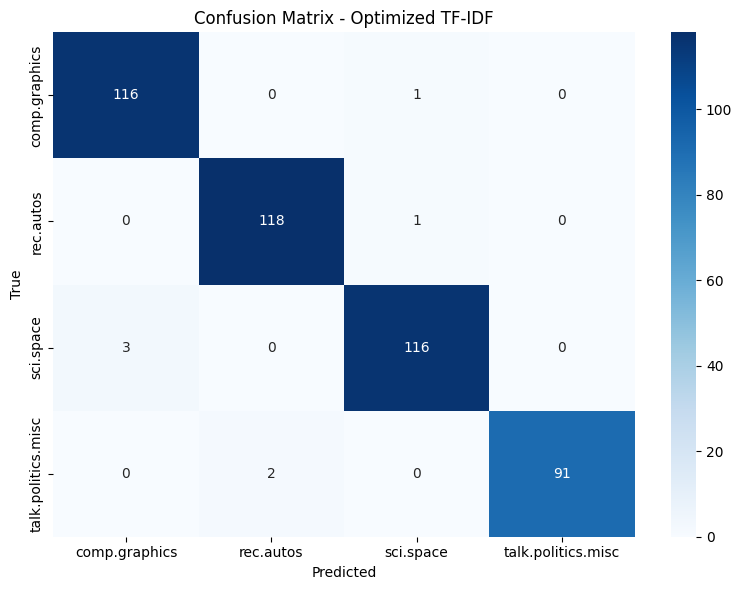

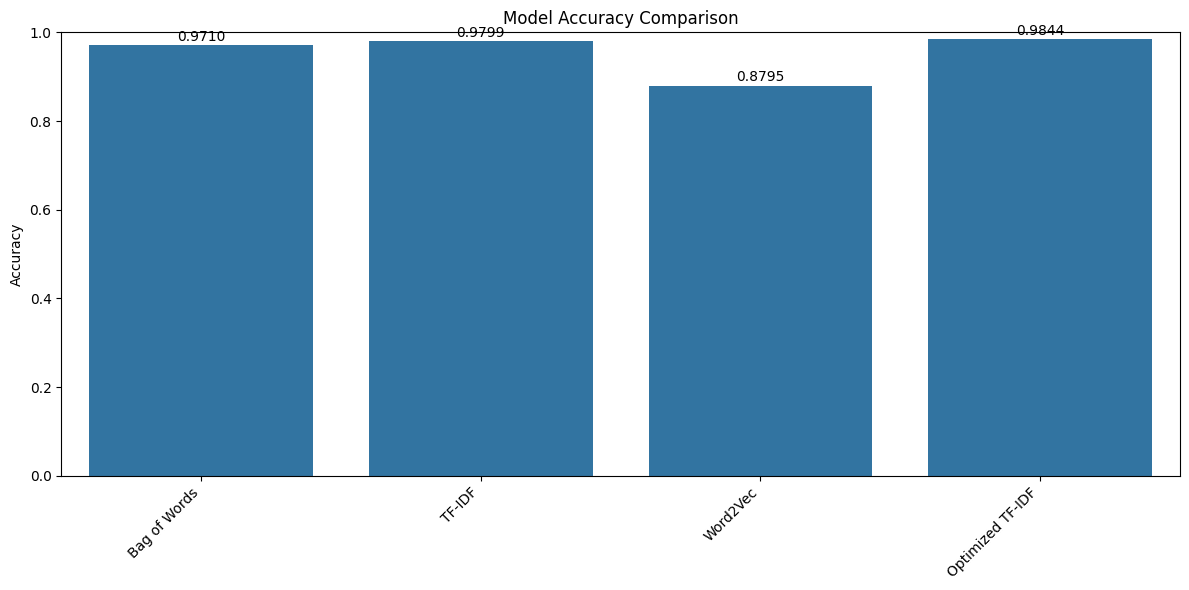

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Create a pipeline for the TF-IDF approach
tfidf_pipeline = Pipeline([
   ('vectorizer', TfidfVectorizer(preprocessor=preprocess_text, lowercase=False)),
   ('classifier', MultinomialNB())
])

# Define parameter grid to search
param_grid = {
   'vectorizer__min_df': [2, 3],
   'vectorizer__max_df': [0.9, 1.0],
   'vectorizer__ngram_range': [(1, 2), (1, 3)],
   'classifier__alpha': [0.5, 1.0]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(
   tfidf_pipeline,
   param_grid,
   cv=5,             # 5-fold cross-validation
   scoring='accuracy',
   verbose=1,
   # n_jobs=-1
)

# Fit the grid search to the data
print("Performing grid search to optimize model hyperparameters...")
grid_search.fit(X_train, y_train)

# Print best parameters and score
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate the optimized model on test data
optimized_pipeline = grid_search.best_estimator_
y_pred_optimized = optimized_pipeline.predict(X_test)
optimized_accuracy = evaluate_model(y_test, y_pred_optimized, "Optimized TF-IDF")

# Add to our model comparison
models.append("Optimized TF-IDF")
accuracies.append(optimized_accuracy)

# Updated plot for model comparison
plt.figure(figsize=(12, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
for i, acc in enumerate(accuracies):
   plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
plt.tight_layout()
plt.show()

Performing grid search to optimize CountVectorizer + Naive Bayes...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters: {'classifier__alpha': 0.5, 'vectorizer__max_df': 0.9, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 2)}
Best cross-validation accuracy: 0.9704

Optimized CountVectorizer Model Performance:
Accuracy: 0.9732

Classification Report:
                    precision    recall  f1-score   support

     comp.graphics       0.96      0.98      0.97       117
         rec.autos       0.98      0.98      0.98       119
         sci.space       0.97      0.95      0.96       119
talk.politics.misc       0.98      0.98      0.98        93

          accuracy                           0.97       448
         macro avg       0.97      0.97      0.97       448
      weighted avg       0.97      0.97      0.97       448



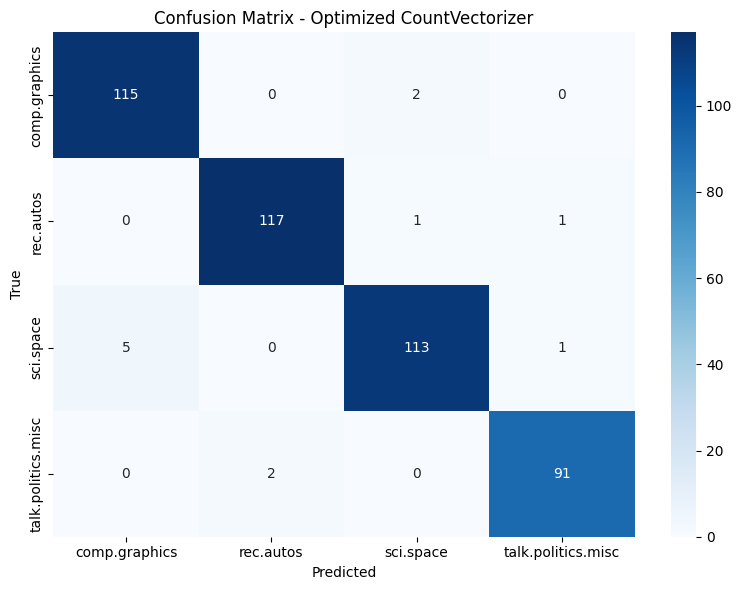

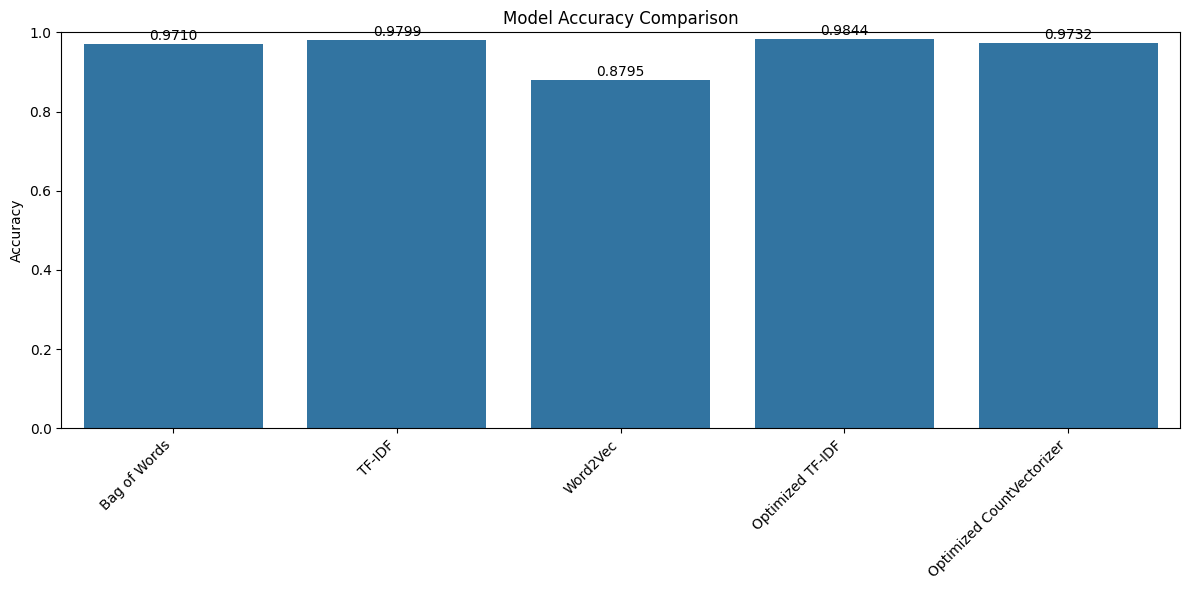

In [13]:
# Create a pipeline with CountVectorizer
count_pipeline = Pipeline([
   ('vectorizer', CountVectorizer(preprocessor=preprocess_text, lowercase=False)),
   ('classifier', MultinomialNB())
])

# Define parameter grid
param_grid = {
   'vectorizer__min_df': [2, 3],
   'vectorizer__max_df': [0.9, 1.0],
   'vectorizer__ngram_range': [(1, 2), (1, 3)],
   'classifier__alpha': [0.5, 1.0]
}

# Grid search with 5-fold CV
grid_search_count = GridSearchCV(
   count_pipeline,
   param_grid,
   cv=5,
   scoring='accuracy',
   verbose=1,
   # n_jobs=-1  # Optional parallelization
)

# Run grid search
print("Performing grid search to optimize CountVectorizer + Naive Bayes...")
grid_search_count.fit(X_train, y_train)

# Best parameters and performance
print(f"\nBest parameters: {grid_search_count.best_params_}")
print(f"Best cross-validation accuracy: {grid_search_count.best_score_:.4f}")

# Evaluate on test set
optimized_pipeline_count = grid_search_count.best_estimator_
y_pred_count = optimized_pipeline_count.predict(X_test)
optimized_accuracy_count = evaluate_model(y_test, y_pred_count, "Optimized CountVectorizer")

# Track performance
models.append("Optimized CountVectorizer")
accuracies.append(optimized_accuracy_count)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
for i, acc in enumerate(accuracies):
   plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
plt.tight_layout()
plt.show()

Optimized TF-IDF model has the highest accuracy for classifying the text.